<a href="https://colab.research.google.com/github/JamesMcGuigan/dlaicourse/blob/master/TensorFlow%20In%20Practice/Course%204%20-%20S%2BP/S%2BP%20Week%202%20Lesson%202.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# !pip install tf-nightly-2.0-preview

In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.2.0-rc1


In [0]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time      = np.arange(4 * 365 + 1, dtype="float32")
baseline  = 10
series    = trend(time, 0.1)  
baseline  = 10
amplitude = 40
slope     = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train    = series[:split_time]
time_valid = time[split_time:]
x_valid    = series[split_time:]

window_size = 20
batch_size  = 32
shuffle_buffer_size = 1000

In [5]:
series.shape, series

((1461,),
 array([ 52.48357 ,  49.35275 ,  53.314735, ...,  91.37325 ,  88.32383 ,
        122.30772 ], dtype=float32))

In [0]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [7]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(dataset)

<PrefetchDataset shapes: ((None, None), (None,)), types: (tf.float32, tf.float32)>


In [8]:
l0    = tf.keras.layers.Dense(1, input_shape=[window_size])
model = tf.keras.models.Sequential([l0])
model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))
model.fit(dataset,epochs=100,verbose=0)

print("Layer weights {}".format(l0.get_weights()))

Layer weights [array([[-8.03550333e-02],
       [ 4.57275705e-03],
       [-3.30334529e-04],
       [ 9.93822888e-02],
       [-2.12868135e-02],
       [ 7.13368207e-02],
       [-1.47990048e-01],
       [ 1.23129010e-01],
       [-7.44403675e-02],
       [ 6.31027892e-02],
       [-1.36763245e-01],
       [ 1.07100405e-01],
       [ 2.00581141e-02],
       [-1.14748087e-02],
       [-1.28272269e-02],
       [ 6.97223935e-03],
       [ 7.83692524e-02],
       [ 2.56485850e-01],
       [ 1.63732111e-01],
       [ 4.76704478e-01]], dtype=float32), array([0.01795154], dtype=float32)]


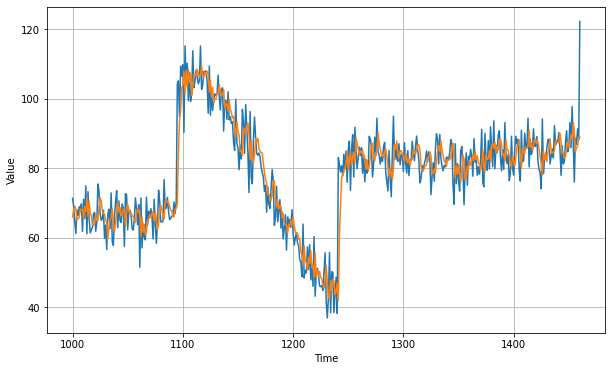

In [22]:
forecast = []

for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results  = np.array(forecast)[:, 0, 0]

plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

Epoch 00153: early stopping


5.430132

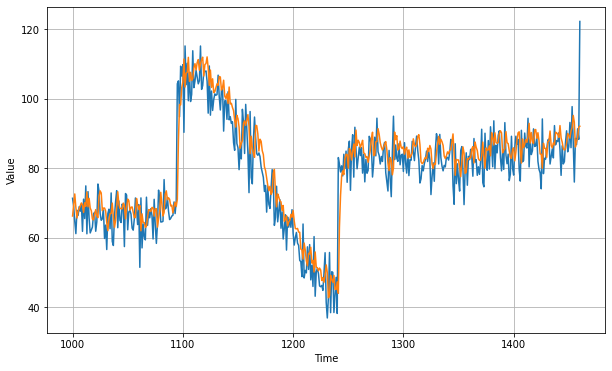

In [16]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(1, input_shape=[window_size]),
])
model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))
model.fit(
    dataset,
    epochs=10000,
    verbose=0, 
    callbacks=[
      tf.keras.callbacks.EarlyStopping(monitor='loss', patience=20, verbose=1)
    ]
)

# print("Layer weights {}".format(l0.get_weights()))

forecast = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results  = np.array(forecast)[:, 0, 0]

plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

Epoch 00309: early stopping


4.9981346

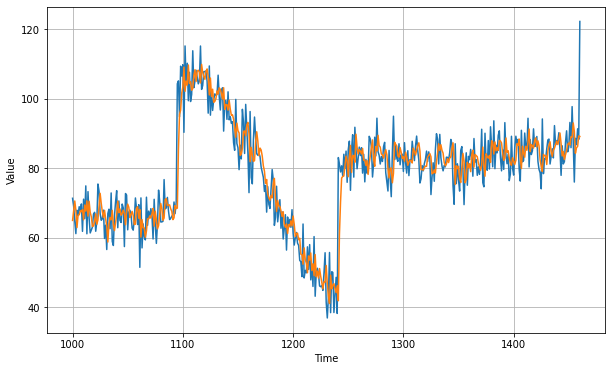

In [12]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(2, input_shape=[window_size]),
])
model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))
model.fit(
    dataset,
    epochs=10000,
    verbose=0, 
    callbacks=[
      tf.keras.callbacks.EarlyStopping(monitor='loss', patience=20, verbose=1)
    ]
)

# print("Layer weights {}".format(l0.get_weights()))

forecast = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results  = np.array(forecast)[:, 0, 0]

plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

Epoch 00358: early stopping


4.94402

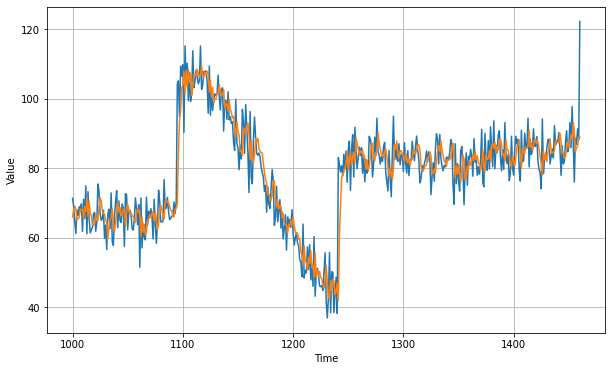

In [21]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(2, input_shape=[window_size]),
  tf.keras.layers.Dense(2),
])
model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))
model.fit(
    dataset,
    epochs=10000,
    verbose=0, 
    callbacks=[
      tf.keras.callbacks.EarlyStopping(monitor='loss', patience=20, verbose=1)
    ]
)

# print("Layer weights {}".format(l0.get_weights()))

forecast = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results  = np.array(forecast)[:, 0, 0]

plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

Epoch 00416: early stopping


5.064139

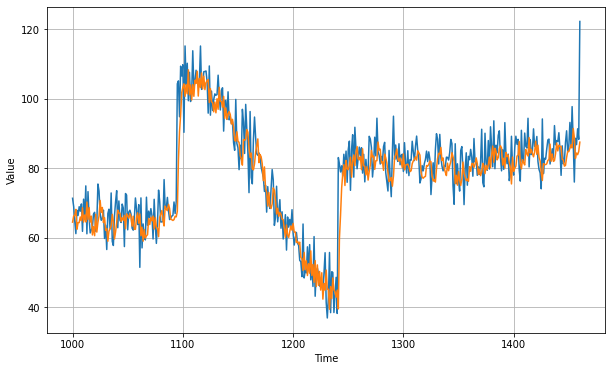

In [18]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(4, input_shape=[window_size]),
])
model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))
model.fit(
    dataset,
    epochs=10000,
    verbose=0, 
    callbacks=[
      tf.keras.callbacks.EarlyStopping(monitor='loss', patience=20, verbose=1)
    ]
)

# print("Layer weights {}".format(l0.get_weights()))

forecast = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results  = np.array(forecast)[:, 0, 0]

plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

Epoch 00496: early stopping


4.983328

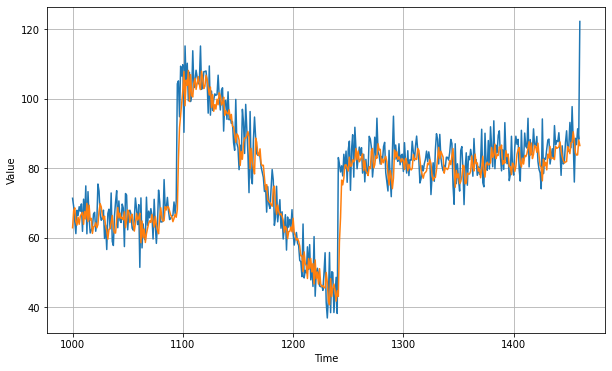

In [17]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(4, input_shape=[window_size]),
  tf.keras.layers.Dense(4),
])
model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))
model.fit(
    dataset,
    epochs=10000,
    verbose=0, 
    callbacks=[
      tf.keras.callbacks.EarlyStopping(monitor='loss', patience=20, verbose=1)
    ]
)

# print("Layer weights {}".format(l0.get_weights()))

forecast = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results  = np.array(forecast)[:, 0, 0]

plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

Epoch 00371: early stopping


4.9553356

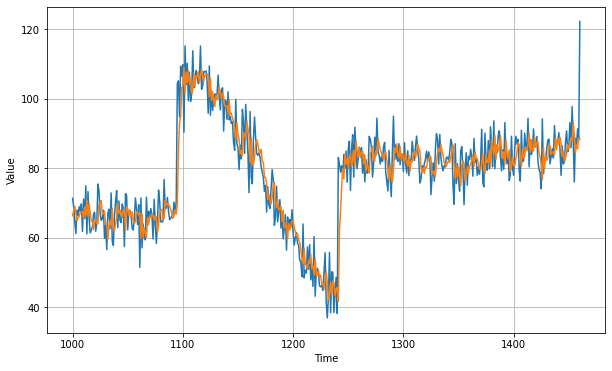

In [19]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(4, input_shape=[window_size]),
  tf.keras.layers.Dense(4),
  tf.keras.layers.Dense(4),
])
model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))
model.fit(
    dataset,
    epochs=10000,
    verbose=0, 
    callbacks=[
      tf.keras.callbacks.EarlyStopping(monitor='loss', patience=20, verbose=1)
    ]
)

# print("Layer weights {}".format(l0.get_weights()))

forecast = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results  = np.array(forecast)[:, 0, 0]

plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

Epoch 00224: early stopping


5.0013814

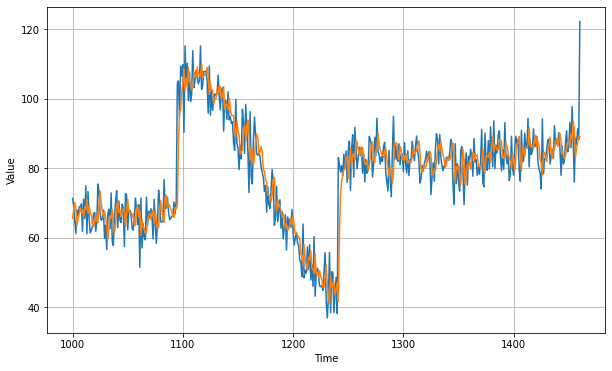

In [20]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(4, input_shape=[window_size]),
  tf.keras.layers.Dense(4),
  tf.keras.layers.Dense(4),
  tf.keras.layers.Dense(4),
])
model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))
model.fit(
    dataset,
    epochs=10000,
    verbose=0, 
    callbacks=[
      tf.keras.callbacks.EarlyStopping(monitor='loss', patience=20, verbose=1)
    ]
)

# print("Layer weights {}".format(l0.get_weights()))

forecast = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results  = np.array(forecast)[:, 0, 0]

plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

Epoch 01002: early stopping


5.118571

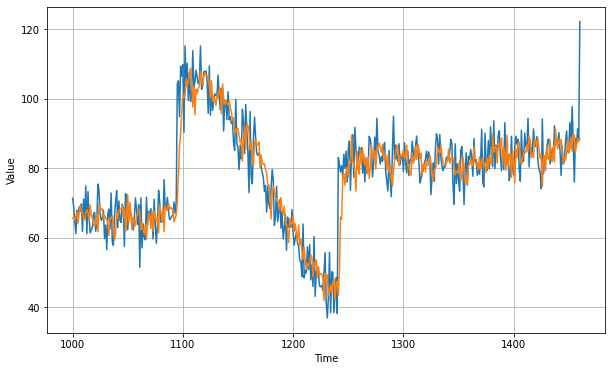

In [13]:
l0    = tf.keras.layers.Dense(128, input_shape=[window_size])
model = tf.keras.models.Sequential([l0])
model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))
model.fit(
    dataset,
    epochs=10000,
    verbose=0, 
    callbacks=[
      tf.keras.callbacks.EarlyStopping(monitor='loss', patience=20, verbose=1)
    ]
)

# print("Layer weights {}".format(l0.get_weights()))

forecast = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results  = np.array(forecast)[:, 0, 0]

plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

Epoch 00506: early stopping


5.1291223

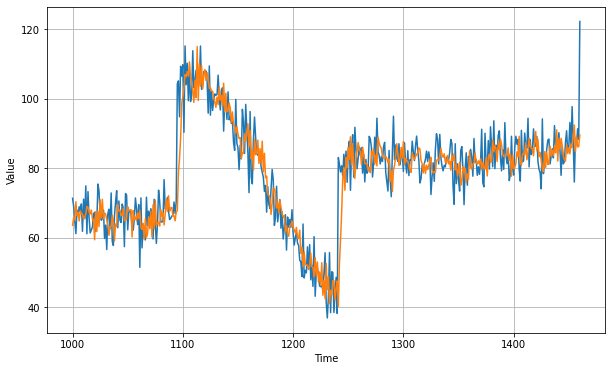

In [14]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(128, input_shape=[window_size]),
  tf.keras.layers.Dense(128)
])
model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))
model.fit(
    dataset,
    epochs=10000,
    verbose=0, 
    callbacks=[
      tf.keras.callbacks.EarlyStopping(monitor='loss', patience=20, verbose=1)
    ]
)

# print("Layer weights {}".format(l0.get_weights()))

forecast = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results  = np.array(forecast)[:, 0, 0]

plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

Epoch 00367: early stopping


4.9498024

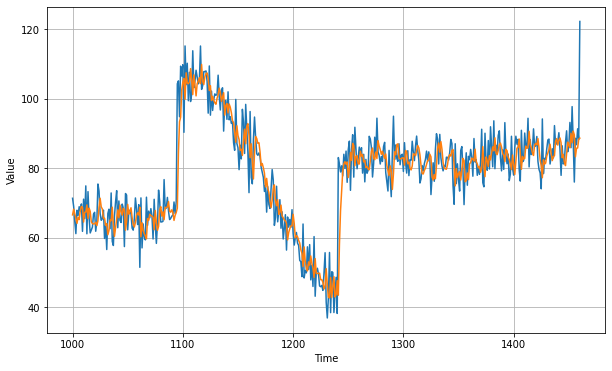

In [15]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(128, input_shape=[window_size]),
  tf.keras.layers.Dense(128),
  tf.keras.layers.Dense(128),
])
model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))
model.fit(
    dataset,
    epochs=10000,
    verbose=0, 
    callbacks=[
      tf.keras.callbacks.EarlyStopping(monitor='loss', patience=20, verbose=1)
    ]
)

# print("Layer weights {}".format(l0.get_weights()))

forecast = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results  = np.array(forecast)[:, 0, 0]

plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()